In [6]:
pip install wget

Note: you may need to restart the kernel to use updated packages.


In [7]:
from wget import download
from os import chdir, getcwd, mkdir, path

In [8]:
folders = 24
dataset_path = 'test'
base_url = 'https://archive.physionet.org/pn6/chbmit/'    # url that contains CHB-MIT Scalp EEG Database

In [9]:
list_of_folders = []
for i in range (1, folders+1):
    if i<10:
        name = 'chb0'
    else:
        name = 'chb'
    list_of_folders.append(name + str(i))

In [10]:
'''
https://stackoverflow.com/questions/1883980/find-the-nth-occurrence-of-substring-in-a-string
'''
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start + len(needle))
        n -= 1
    return start

In [11]:
initial_path = getcwd()
if not path.exists(dataset_path):
    mkdir(dataset_path)
chdir(dataset_path)


files = []
# for every folder contained in the dataset
for l in list_of_folders:

    # check if the folder already exists, otherwise create it
    if not path.exists(l):
        mkdir(l)
        print('Creation of the directory', l, 'succeeded')
    else:
        print ('Directory', l,  'already exists')

    # change the working directory to the current list's file
    chdir(l)

    # for the current folder, download the 'MD5SUMS' file that enumerates all the files contained in the folder.
    # save the names of the files in a list
    folder_url = base_url + l
    url = folder_url + '/' + 'MD5SUMS'
    print ('Downloading ', url, 'to ', getcwd())
    if not path.isfile('MD5SUMS'):
        download(url)
    else:
        print('File MD5SUMS already exists to ', getcwd())
    f = open('MD5SUMS','r')
    lines = f.readlines()
    f.close()
    # for each folder download all the files that contains
    for line in lines:
        fname = line[line.find('chb'):line.find('\n')].strip()
        url = folder_url + '/' + fname

        # check if we have already downloaded the file
        if not path.isfile(fname) and fname.endswith('.seizures'):
            print ('Downloading ', url[:find_nth(url, '.seizures', 1)], 'to ', getcwd())
            download(url[:find_nth(url, '.seizures', 1)])
            print ('Downloading ', url, 'to ', getcwd())
            download(url)

    # change the working directory to the parent folder
    chdir('..')
chdir(initial_path)

Directory chb01 already exists
File MD5SUMS already exists to  /Users/mangoman/Downloads/test/chb01
Directory chb02 already exists
File MD5SUMS already exists to  /Users/mangoman/Downloads/test/chb02
Directory chb03 already exists
File MD5SUMS already exists to  /Users/mangoman/Downloads/test/chb03
Directory chb04 already exists
File MD5SUMS already exists to  /Users/mangoman/Downloads/test/chb04
Directory chb05 already exists
File MD5SUMS already exists to  /Users/mangoman/Downloads/test/chb05
Directory chb06 already exists
File MD5SUMS already exists to  /Users/mangoman/Downloads/test/chb06
Directory chb07 already exists
File MD5SUMS already exists to  /Users/mangoman/Downloads/test/chb07
Directory chb08 already exists
File MD5SUMS already exists to  /Users/mangoman/Downloads/test/chb08
Directory chb09 already exists
File MD5SUMS already exists to  /Users/mangoman/Downloads/test/chb09
Directory chb10 already exists
File MD5SUMS already exists to  /Users/mangoman/Downloads/test/chb10


In [12]:
!pip install antropy

In [13]:
!pip3 install pyedflib
!pip3 install PyWavelets

In [14]:
import pyedflib as edf
import numpy as np
import glob
import pandas as pd
import random
import antropy as ent
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt, find_peaks, periodogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical

In [15]:
!pip install wfdb

In [16]:
!pip install mne

In [17]:
!pip install wfdb
import wfdb
import gc

!pip install mne


import mne
import re
import tqdm
import logging

In [24]:
ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3','P3-O1',
             'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
             'FZ-CZ', 'CZ-PZ']

In [25]:
path2pt = '/Users/mangoman/Downloads/test'

folders = sorted(glob.glob(path2pt+'/*/'))
n_patient = [m[-2:] for m in [l.rsplit('/', 2)[-2] for l in folders]]

print(*n_patient)

01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24


In [26]:
random.seed(2023)

ratio_train = 0.8
train_patient_str = sorted(random.sample(n_patient, round(ratio_train*len(n_patient))))
test_patient_str = sorted([l for l in n_patient if l not in train_patient_str])
print('Train PT: ', *train_patient_str)
print('Test PT: ', *test_patient_str)

Train PT:  02 03 04 05 06 09 11 12 13 14 15 16 17 18 19 20 21 23 24
Test PT:  01 07 08 10 22


In [27]:
files_train = []
for l in train_patient_str:
    files_train = files_train + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

files_test = []
for l in test_patient_str:
    files_test = files_test + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

In [28]:
len(files_train), len(files_test)

(116, 25)

In [30]:
mne.set_log_level(verbose='ERROR')

In [31]:
import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [32]:
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

time_window = 8
time_step = 4

if os.path.exists('/kaggle/input/mit-chb-processed/signal_samples.npy')&os.path.exists('/kaggle/input/mit-chb-processed/is_sz.npy'):
    array_signals=np.load('/kaggle/input/mit-chb-processed/signal_samples.npy')
    array_is_sz=np.load('/kaggle/input/mit-chb-processed/is_sz.npy')
else:
    p = 0.01
    counter = 0
    for temp_f in files_train:
        temp_edf =  mne.io.read_raw_edf(temp_f)
        temp_labels = temp_edf.ch_names
        if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
            time_window = 8
            time_step = 4
            fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
            step_window = time_window*fs
            step = time_step*fs

            temp_is_sz = np.zeros((temp_edf.n_times,))
            if os.path.exists(temp_f+'.seizures'):
                temp_annotation = wfdb.rdann(temp_f, 'seizures')
                for i in range(int(temp_annotation.sample.size/2)):
                    temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
            temp_len = temp_edf.n_times

            temp_is_sz_ind = np.array(
                [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
            )

            temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
            temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

            counter = counter + temp_0_sample_size + temp_1_sample_size
        temp_edf.close()

    array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
    array_is_sz = np.zeros(counter, dtype=bool)

    counter = 0
    for n, temp_f in enumerate(tqdm.tqdm(files_train)):
        to_log = 'No. {}: Reading. '.format(n)
        temp_edf =  mne.io.read_raw_edf(temp_f)
        temp_labels = temp_edf.ch_names
        n_label_match = sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])
        if n_label_match==len(ch_labels):
            ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
            temp_edf.rename_channels(ch_mapping)
            #temp_edf = temp_edf.pick(ch_labels)

            temp_is_sz = np.zeros((temp_edf.n_times,))
            temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

            if os.path.exists(temp_f+'.seizures'):
                to_log = to_log+'sz exists.'
                temp_annotation = wfdb.rdann(temp_f, 'seizures')
                for i in range(int(temp_annotation.sample.size/2)):
                    temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
            else:
                to_log = to_log+'No sz.'

            temp_len = temp_edf.n_times

            time_window = 8
            time_step = 4
            fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
            step_window = time_window*fs
            step = time_step*fs

            temp_is_sz_ind = np.array(
                [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
            )
            del temp_is_sz

            temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
            temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

            # sz data
            temp_ind = list(np.where(temp_is_sz_ind>0)[0])
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
                array_is_sz[counter] = True
                counter = counter+1

            # no sz data
            temp_ind = random.sample(list(np.where(temp_is_sz_ind==0)[0]), temp_0_sample_size)
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
                array_is_sz[counter] = False
                counter = counter+1

            to_log += '{} signals added: {} w/o sz, {} w/ sz.'.format(
                temp_0_sample_size+temp_1_sample_size, temp_0_sample_size, temp_1_sample_size
            )

        else:
            to_log += 'Not appropriate channel labels. Reading skipped.'.format(n)

        logger.info(to_log)
        temp_edf.close()

        if n%10==0:
            gc.collect()
    gc.collect()

    np.save('signal_samples', array_signals)
    np.save('is_sz', array_is_sz)

100%|█████████████████████████████████████████| 116/116 [00:16<00:00,  7.23it/s]


In [33]:
array_signals.shape

(3913, 18, 2048)

In [34]:
array_signals = array_signals[:, :, ::2]

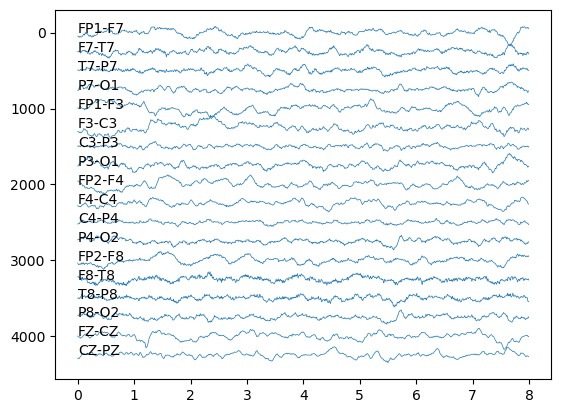

In [36]:
# show a sample of extracted signals (the last one)

vertical_width = 250
signals = array_signals[-1, :, :]
fs = 128

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()

In [37]:
# Checking how much of signals have seizure inside.

array_n = np.where(array_is_sz>.0)[0]
print('Number of all the extracted signals: {}'.format(array_is_sz.size))
print('Number of signals with seizures: {}'.format(array_n.size))
print('Ratio of signals with seizures: {:.3f}'.format(array_n.size/array_is_sz.size))

Number of all the extracted signals: 3913
Number of signals with seizures: 2581
Ratio of signals with seizures: 0.660


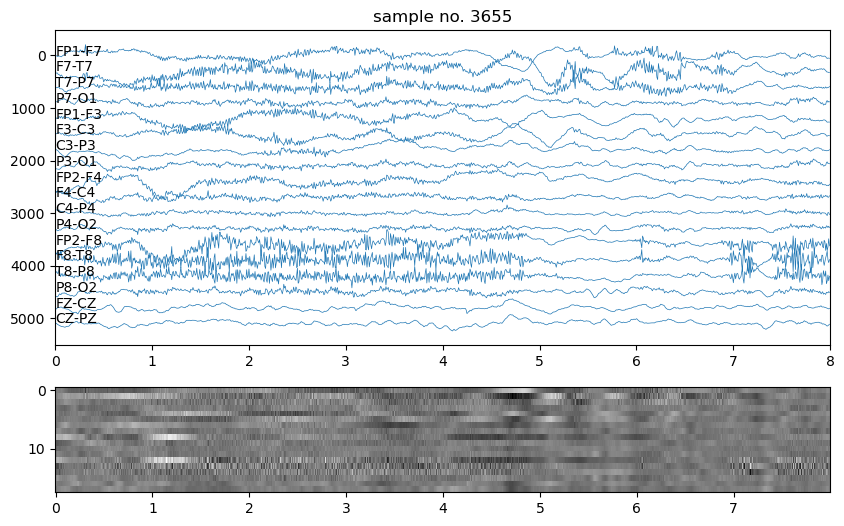

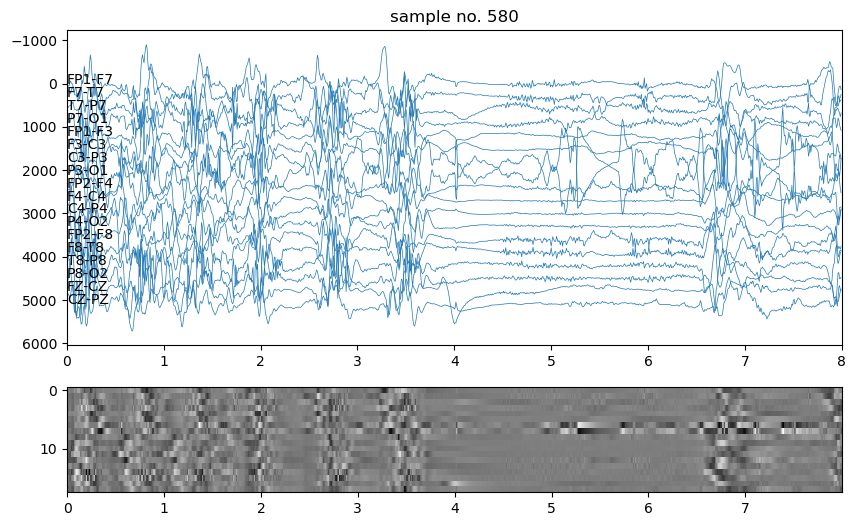

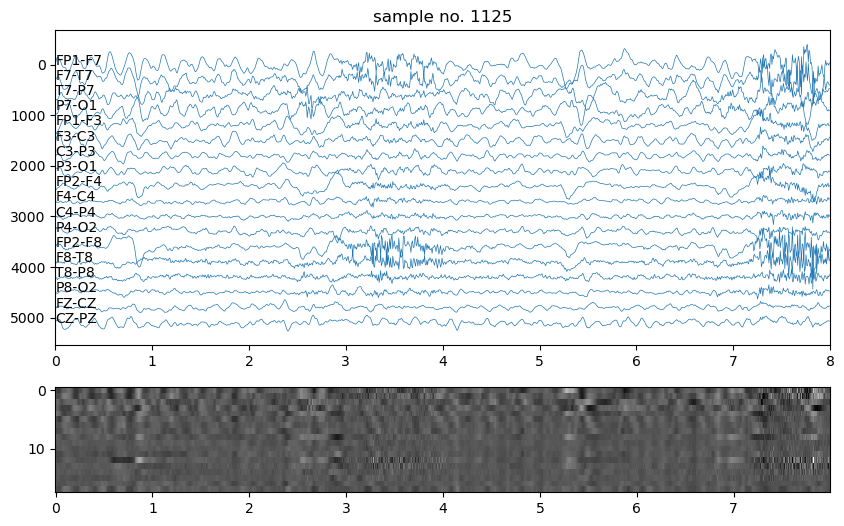

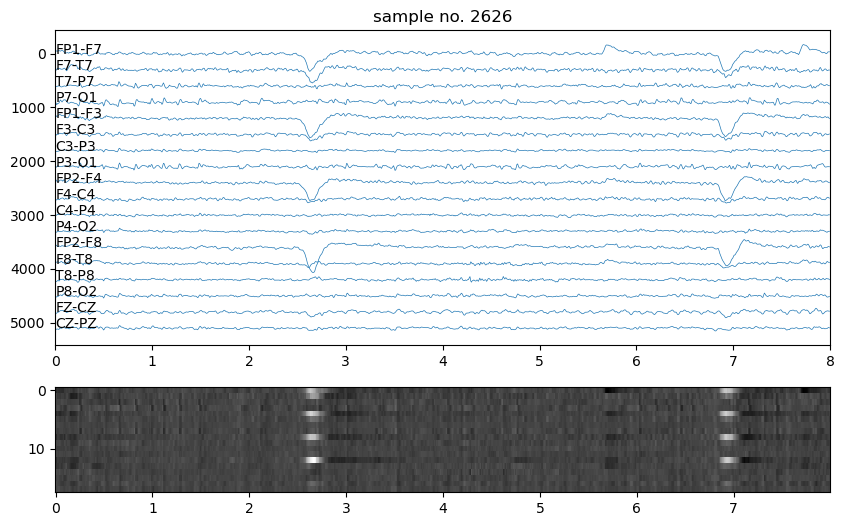

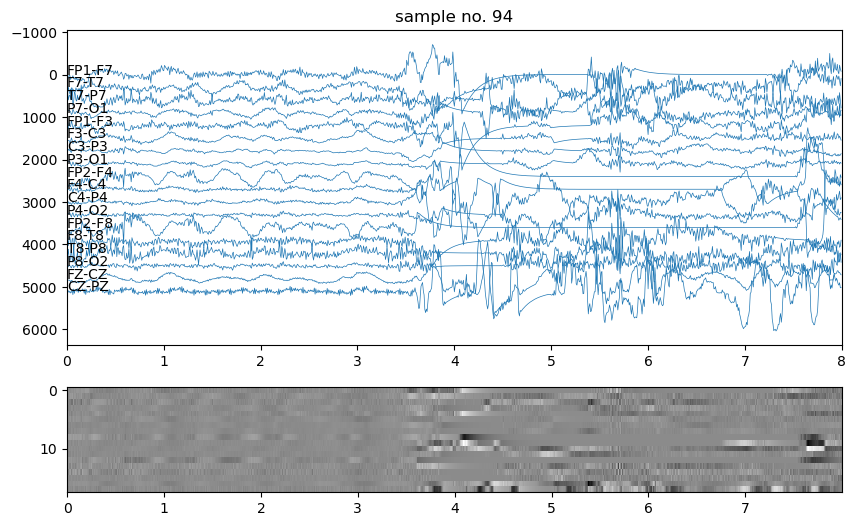

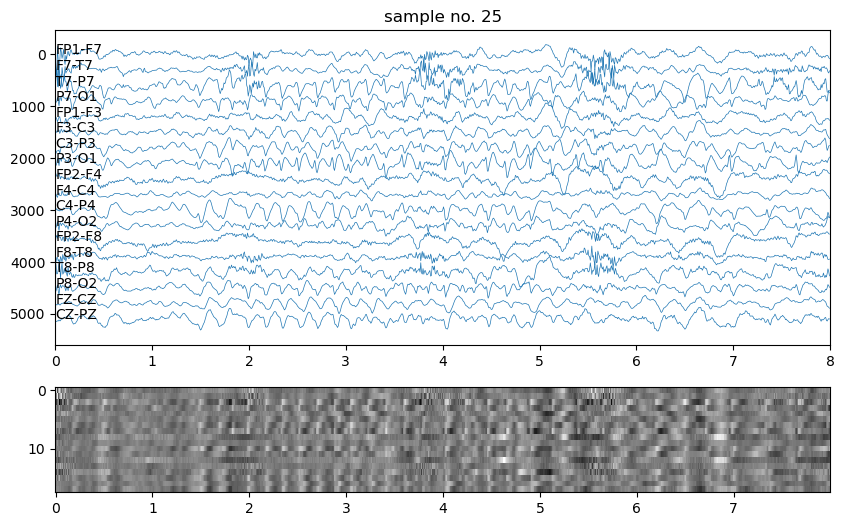

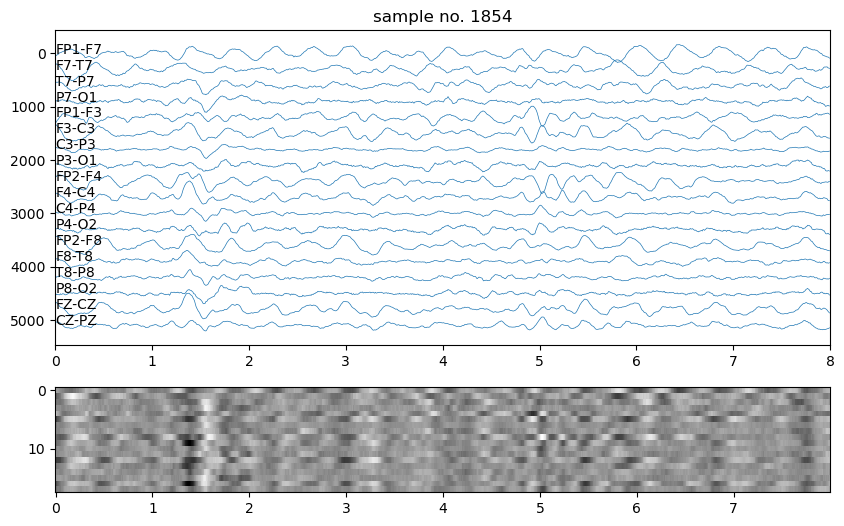

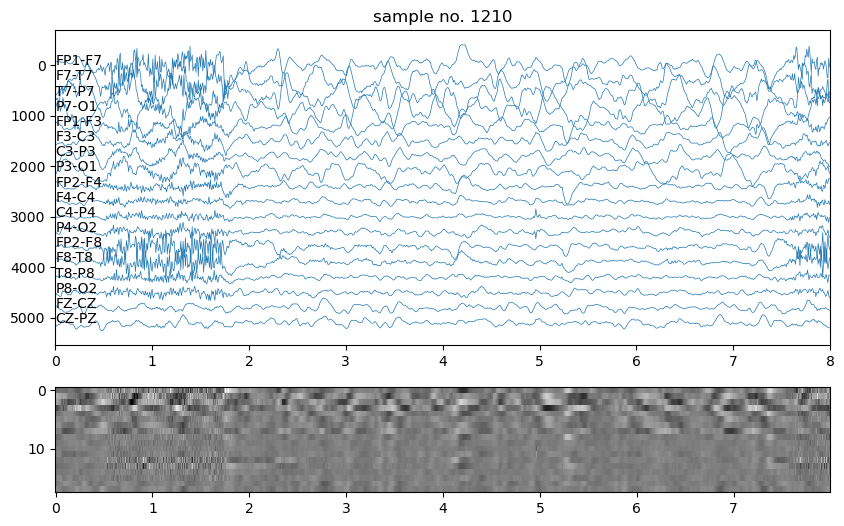

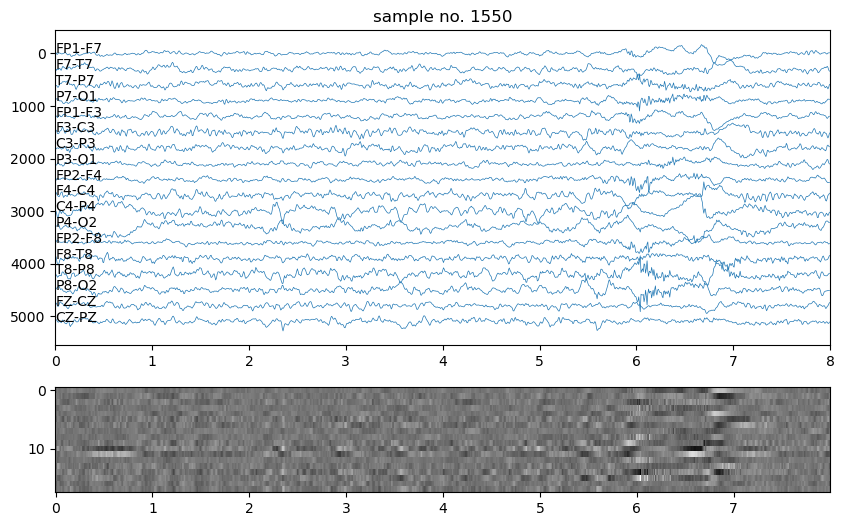

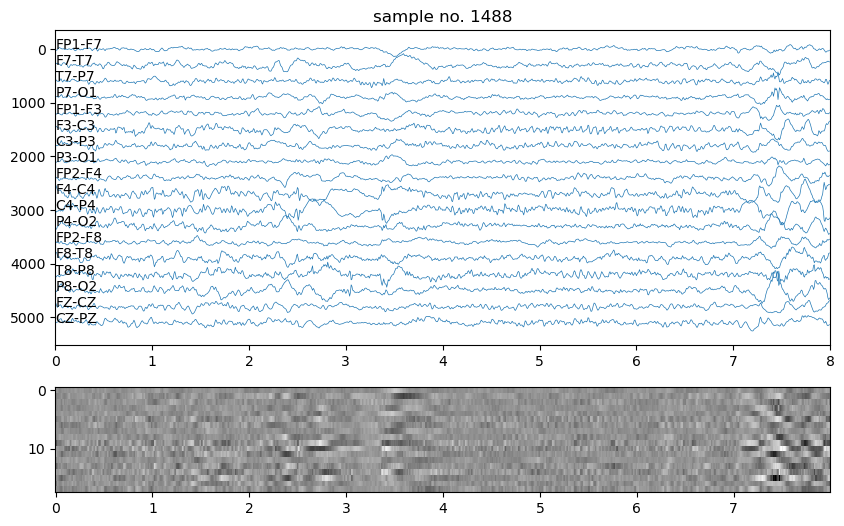

In [38]:
# Let's see samples with seizures.

for n in random.sample(list(array_n), 10):

    vertical_width = 300
    temp_signals = array_signals[n, :, :]
    fs = 128

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})
    for i in range(temp_signals.shape[0]):
        ax[0].plot(np.arange(temp_signals.shape[-1])/fs, temp_signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
        ax[0].annotate(ch_labels[i], xy=(0, i*vertical_width))
    ax[0].invert_yaxis()
    ax[0].set_xlim(0, 8)
    ax[0].set_title('sample no. {}'.format(n))

    ax[1].pcolormesh(np.arange(temp_signals.shape[-1])/fs, np.arange(len(ch_labels)), temp_signals[:, :], cmap='gray')
    ax[1].invert_yaxis()

    plt.show()

In [39]:
from sklearn import model_selection

In [40]:
array_signals = array_signals[:, :, :, np.newaxis]

array_signals.shape

(3913, 18, 1024, 1)

In [42]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(
    array_signals, array_is_sz, test_size=0.3,
    stratify=(array_is_sz>0))

del array_signals, array_is_sz

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [64]:
model = keras.models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), strides=(1, 2),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [66]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 18, 1024, 64)   │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 18, 512, 64)    │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 18, 256, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 256, 128)   │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 128, 128)   │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 64, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 64, 256)     │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 32, 256)     │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,910,657 (7.29 MB)

 Trainable params: 1,910,657 (7.29 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [70]:
from keras.utils import plot_model
#plot_model(model, show_shapes=True, to_file='model.png')
plot_model(model, show_shapes=True, dpi=70)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [72]:
LEARNING_RATE = 1e-4
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy'])

In [74]:
# callbacks
VERBOSE=1
#lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, verbose=VERBOSE, min_le=1e-8)
es = EarlyStopping(monitor='val_loss', patience=20, verbose=VERBOSE, mode='auto', restore_best_weights=True)

callbacks = [es]

In [76]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2739, 18, 1024, 1), (2739,), (1174, 18, 1024, 1), (1174,))

In [78]:
hist = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val),
    epochs=6,
    batch_size=256,
    callbacks=callbacks
)

Epoch 1/6
11/11 ━━━━━━━━━━━━━━━━━━━━ 121s 11s/step - accuracy: 0.6176 - loss: 0.6915 - val_accuracy: 0.6593 - val_loss: 0.5975
Epoch 2/6
11/11 ━━━━━━━━━━━━━━━━━━━━ 97s 9s/step - accuracy: 0.6475 - loss: 0.6242 - val_accuracy: 0.6593 - val_loss: 0.5935
Epoch 3/6
11/11 ━━━━━━━━━━━━━━━━━━━━ 88s 8s/step - accuracy: 0.6528 - loss: 0.6270 - val_accuracy: 0.6593 - val_loss: 0.5870
Epoch 4/6
11/11 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.6705 - loss: 0.6012 - val_accuracy: 0.6593 - val_loss: 0.5774
Epoch 5/6
11/11 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.6579 - loss: 0.5957 - val_accuracy: 0.6670 - val_loss: 0.5676
Epoch 6/6
11/11 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.6782 - loss: 0.5647 - val_accuracy: 0.6695 - val_loss: 0.5466
Restoring model weights from the end of the best epoch: 6.


In [80]:
model.save('CHB_MIT_sz_detec_demo.h5')

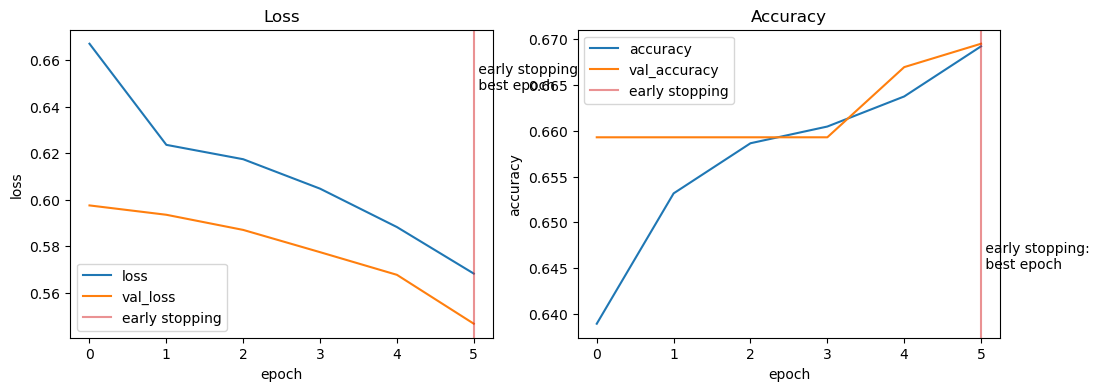

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(hist.history['loss'], label='loss')
ax[0].plot(hist.history['val_loss'], label='val_loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
r = .2
temp_y = r*min(hist.history['loss'])+(1-r)*max(hist.history['loss'])
ax[0].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(hist.history['accuracy'], label='accuracy')
ax[1].plot(hist.history['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
r = .8
temp_y = r*min(hist.history['accuracy'])+(1-r)*max(hist.history['accuracy'])
ax[1].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
ax[1].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [84]:
def sampling_data_pred(f, verbose=True):
    list_signals = []
    list_is_sz = []
    #n_sample = 40
    if verbose==True:
        print('{}: Reading. '.format(f))
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

        if os.path.exists(f+'.seizures'):
            if verbose==True:
                print('sz exists.', end=' ')
            temp_annotation = wfdb.rdann(f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
        #else:
            #print('No sz.', end=' ')

        temp_len = temp_edf.n_times

        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
        step_window = time_window*fs
        step = time_step*fs

        # sampling all signals
        temp_array_signals = np.array([temp_signals[:, i*step:i*step+step_window] for i in range((temp_len-step_window)//step)])
        temp_is_sz_ind = np.array([temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)])
    else:
        if verbose==True:
            print('EEG {}: Not appropriate channel labels. Reading skipped.'.format(n))

    return temp_array_signals, temp_is_sz_ind

In [86]:

list_pred = []
list_true = []

for f in tqdm.tqdm(files_test):
    array_signals, array_is_sz = sampling_data_pred(f, verbose=False)
    array_signals = array_signals[:, :, ::2, np.newaxis]

    list_pred.append(model.predict(array_signals, verbose=0))
    list_true.append(array_is_sz)

100%|███████████████████████████████████████████| 25/25 [04:13<00:00, 10.15s/it]


In [88]:
from sklearn import metrics

In [90]:
# threshold = 0.5
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.5)
print(report)

              precision    recall  f1-score   support

       False       0.99      0.01      0.02     33250
        True       0.02      0.99      0.04       629

    accuracy                           0.03     33879
   macro avg       0.50      0.50      0.03     33879
weighted avg       0.97      0.03      0.03     33879



In [92]:
# threshold = 0.9
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.9)
print(report)

              precision    recall  f1-score   support

       False       0.98      1.00      0.99     33250
        True       0.59      0.20      0.29       629

    accuracy                           0.98     33879
   macro avg       0.79      0.60      0.64     33879
weighted avg       0.98      0.98      0.98     33879



In [94]:
roc = metrics.roc_curve(np.concatenate(list_true)>0, np.concatenate(list_pred))
auc = metrics.roc_auc_score(np.concatenate(list_true)>0, np.concatenate(list_pred))

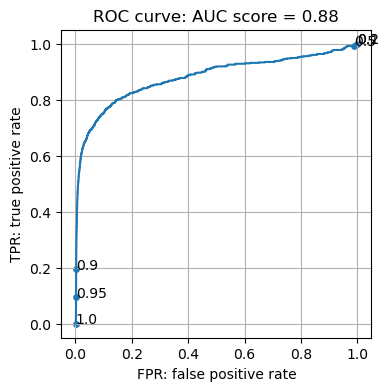

In [96]:
plt.figure(figsize=(4, 4))
plt.plot(roc[0][np.argmin(np.abs(roc[2]-1)):], roc[1][np.argmin(np.abs(roc[2]-1)):])
plt.xlabel('FPR: false positive rate')
plt.ylabel('TPR: true positive rate')
plt.title('ROC curve: AUC score = {:.2f}'.format(auc))

th = [.1, .2, .5, .9, .95, 1.]
ind = [np.argmin(np.abs(roc[2]-l)) for l in th]
plt.scatter(roc[0][ind], roc[1][ind], s=15)
for i, l in enumerate(ind):
    plt.annotate("{}".format(th[i]), xy=(roc[0][l], roc[1][l]))
#plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], color='black', linewidth=1)
plt.ylim(-.05, 1.05)
plt.xlim(-.05, 1.05)
plt.grid()
#plt.axis('off')
plt.show()

In [98]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

# Function to create the MLP model
def create_model(hidden_layer_sizes, alpha, learning_rate_init):
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha, learning_rate_init=learning_rate_init, max_iter=6)

    return model

# Define the hyperparameter search space
param_dist = {
    'hidden_layer_sizes': [(100,), (200,), (300,)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0001, 0.001, 0.01]
}

# Wrap the model creation function
model = MLPClassifier(max_iter=6)  # You can adjust max_iter based on your needs

# Create a random search object
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2)

# Reshape the input data
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Rest of your code remains the same
# ...

# Fit the random search to your data
random_search.fit(X_train_reshaped, y_train)


# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.0001; total time=   2.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.0001; total time=   1.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.0001; total time=   1.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(200,), learning_rate_init=0.0001; total time=   2.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(200,), learning_rate_init=0.0001; total time=   2.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(200,), learning_rate_init=0.0001; total time=   2.3s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(300,), learning_rate_init=0.0001; total time=   3.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(300,), learning_rate_init=0.0001; total time=   3.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(300,), learning_rate_init=0.0001; total time=   3.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(200,), learning_rate_init=0.0001; total time=   2.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(200,), learning_rate_init=0.0001; total time=   2.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(200,), learning_rate_init=0.0001; total time=   2.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   1.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   1.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   1.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01; total time=   1.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01; total time=   1.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(100,), learning_rate_init=0.01; total time=   2.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(300,), learning_rate_init=0.01; total time=   3.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(300,), learning_rate_init=0.01; total time=   4.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(300,), learning_rate_init=0.01; total time=   3.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(200,), learning_rate_init=0.001; total time=   2.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(200,), learning_rate_init=0.001; total time=   2.7s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(200,), learning_rate_init=0.001; total time=   2.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.001; total time=   3.7s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.001; total time=   3.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.001; total time=   3.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.01; total time=   3.7s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.01; total time=   3.7s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.01; total time=   3.5s
Best Hyperparameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (300,), 'alpha': 0.01}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


In [100]:
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (300,), 'alpha': 0.01}


In [102]:
for i, f in enumerate(files_test):
    if os.path.exists(f+'.seizures'):
        print('Index = {} has seizures: {}'.format(i, f))

Index = 0 has seizures: /Users/mangoman/Downloads/test/chb01/chb01_21.edf
Index = 1 has seizures: /Users/mangoman/Downloads/test/chb01/chb01_26.edf
Index = 2 has seizures: /Users/mangoman/Downloads/test/chb01/chb01_18.edf
Index = 3 has seizures: /Users/mangoman/Downloads/test/chb01/chb01_15.edf
Index = 4 has seizures: /Users/mangoman/Downloads/test/chb01/chb01_03.edf
Index = 5 has seizures: /Users/mangoman/Downloads/test/chb01/chb01_16.edf
Index = 6 has seizures: /Users/mangoman/Downloads/test/chb01/chb01_04.edf
Index = 7 has seizures: /Users/mangoman/Downloads/test/chb07/chb07_19.edf
Index = 8 has seizures: /Users/mangoman/Downloads/test/chb07/chb07_13.edf
Index = 9 has seizures: /Users/mangoman/Downloads/test/chb07/chb07_12.edf
Index = 10 has seizures: /Users/mangoman/Downloads/test/chb08/chb08_11.edf
Index = 11 has seizures: /Users/mangoman/Downloads/test/chb08/chb08_05.edf
Index = 12 has seizures: /Users/mangoman/Downloads/test/chb08/chb08_13.edf
Index = 13 has seizures: /Users/man

In [104]:
def moving_ave(a, n):
    if len(a.shape)!=1:
        print('Not 1 dimension array. return nothing.')
        return
    temp = np.zeros(a.size-n)
    for i in range(n):
        temp = temp+a[i:-n+i]
    temp = temp/n

    return temp

In [106]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import os

# Function to create the MLP model
def create_model(hidden_layer_sizes, alpha, learning_rate_init):
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha, learning_rate_init=learning_rate_init, max_iter=6)
    return model

# Define the hyperparameter search space
param_dist = {
    'hidden_layer_sizes': [(100,), (200,), (300,)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0001, 0.001, 0.01]
}

# Wrap the model creation function
model = MLPClassifier(max_iter=6)  # You can adjust max_iter based on your needs

# Create a random search object
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2)

# Reshape the input data
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Fit the random search to your data
random_search.fit(X_train_reshaped, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# After fitting, access the best model
best_model = random_search.best_estimator_

# Now use the best model for predictions
# get signals and labels from test data.
n = 20
array_signals, array_is_sz = sampling_data_pred(files_test[n])

# preprocess
array_signals = array_signals[:, :, ::2, np.newaxis]

# Reshape the test data to match the expected input shape (if necessary)
# Assuming array_signals should be 2D for MLPClassifier (samples, features)
array_signals_reshaped = array_signals.reshape(array_signals.shape[0], -1)

# Now predict using the best model found by RandomizedSearchCV
pred = best_model.predict(array_signals_reshaped)

print(pred)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(300,), learning_rate_init=0.001; total time=   3.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(300,), learning_rate_init=0.001; total time=   3.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(300,), learning_rate_init=0.001; total time=   4.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.01; total time=   1.9s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.01; total time=   1.7s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.01; total time=   1.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.0001; total time=   1.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.0001; total time=   1.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.0001; total time=   2.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.0001; total time=   4.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.0001; total time=   4.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.0001; total time=   4.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(300,), learning_rate_init=0.01; total time=   6.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(300,), learning_rate_init=0.01; total time=   4.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(300,), learning_rate_init=0.01; total time=   4.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(300,), learning_rate_init=0.0001; total time=   3.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(300,), learning_rate_init=0.0001; total time=   4.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.0001, hidden_layer_sizes=(300,), learning_rate_init=0.0001; total time=   3.9s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(300,), learning_rate_init=0.01; total time=   3.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(300,), learning_rate_init=0.01; total time=   4.2s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(300,), learning_rate_init=0.01; total time=   3.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.001; total time=   4.9s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.001; total time=   3.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(300,), learning_rate_init=0.001; total time=   3.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(200,), learning_rate_init=0.001; total time=   2.6s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(200,), learning_rate_init=0.001; total time=   3.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.001, hidden_layer_sizes=(200,), learning_rate_init=0.001; total time=   2.7s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   1.7s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   1.7s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END alpha=0.01, hidden_layer_sizes=(100,), learning_rate_init=0.001; total time=   1.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  warnings.warn(


Best Hyperparameters: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (300,), 'alpha': 0.0001}
/Users/mangoman/Downloads/test/chb10/chb10_30.edf: Reading. 
sz exists. [ True  True  True ... False  True  True]


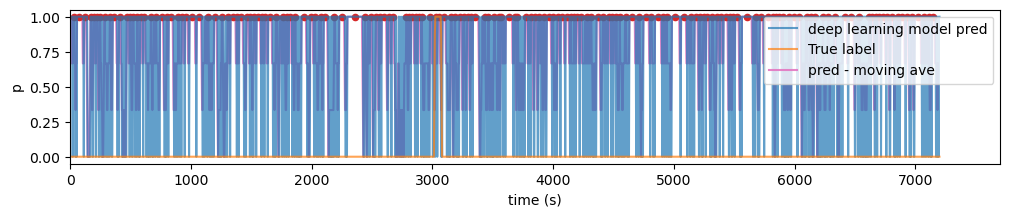

In [110]:
time_window = 8
time_step = 4
mv_win = 3

fig, ax = plt.subplots(figsize=(12, 2))

ax.plot(np.arange(pred.size)*time_step, pred.flatten(), alpha=0.7, label='deep learning model pred')
ax.plot(np.arange(pred.size)*time_step, array_is_sz, alpha=.7, label='True label')

pred_moving_ave = moving_ave(pred.flatten(), mv_win)
pred_peaks, _ = find_peaks(pred_moving_ave, height=.95, distance=6)
ax.plot(np.arange(pred.size-mv_win)*time_step, pred_moving_ave,
        alpha=.9, label='pred - moving ave', color='tab:pink', zorder=0)
ax.scatter(pred_peaks*time_step, pred_moving_ave[pred_peaks], s=20, color='tab:red')

ax.set_xlabel('time (s)')
ax.set_ylabel('p')
ax.set_xlim(0, pred.size*time_step+500)
ax.legend(loc='upper right')
plt.show()

In [112]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you have already reshaped your data
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)

# Create an instance of MLPClassifier with the best hyperparameters from your search
best_params = {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'alpha': 0.0001}
model = MLPClassifier(max_iter=15, **best_params)

# Train the model
model.fit(X_train_reshaped, y_train)

# Make predictions on the validation set
y_val_pred = model.predict(X_val_reshaped)

# Evaluate the accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", accuracy)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation Accuracy: 0.5562180579216355


In [113]:
from sklearn.metrics import f1_score

# Make predictions on the training set
y_val_pred = model.predict(X_val_reshaped)

# Compute the F1 score for the training set
f1_test = f1_score(y_val, y_val_pred)
print("Training F1 Score:", f1_test)

Training F1 Score: 0.6670926517571885
